In [ ]:
pip install -U git+https://github.com/albumentations-team/albumentations


  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-b40me4ah
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-b40me4ah


In [ ]:
pip uninstall opencv-python  #Version issues so unistalling and than installing the required version

In [ ]:
pip install opencv-python-headless==4.1.2.30

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import albumentations as A
import cv2
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1

In [ ]:
transform = A.Compose([A.CenterCrop(width=320, height=320)], bbox_params=A.BboxParams(format='pascal_voc', min_area= 300))

In [ ]:
image_data = []
box_data = []

image_path = '/content/drive/MyDrive/DL/object_detection/Images'
box_path = '/content/drive/MyDrive/DL/object_detection/Boxes'

num_data = 40
#Loading Images
print("Loading Training Images...")
filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
i = 0
for img in filenames:
  image_arr = cv2.imread(img)
  image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
  image_data.append(image_arr)

#Loading Bounding Boxes
print("Loading Bounding Boxes...")
filenames = [os.path.join(box_path, img) for img in os.listdir(box_path)]
filenames.sort()
i = 0

boxes = []
names = []

for boxl in filenames:
  tree = ET.parse(boxl)
  root = tree.getroot()

  btemp = []
  for neighbor in root.iter('bndbox'):
    xmin = int(float(neighbor.find('xmin').text))
    ymin = int(float(neighbor.find('ymin').text))
    xmax = int(float(neighbor.find('xmax').text))
    ymax = int(float(neighbor.find('ymax').text))

    btemp.append([xmin, ymin, xmax, ymax])

  boxes.append(btemp)

  ltemp = []
  for name_ in root.iter('object'):
    n1 = name_.find('name')
    ltemp.append(n1.text)
  names.append(ltemp)
  
print("No of Images: ", len(image_data))
print("Length of Bounding boxes: ", len(boxes))
print("Length of Bounding boxes names(labels): ", len(names))

Loading Training Images...
Loading Bounding Boxes...
No of Images:  4952
Length of Bounding boxes:  4952
Length of Bounding boxes names(labels):  4952


In [ ]:
#Person: person
#Animal: bird, cat, cow, dog, horse, sheep
#Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
#Indoor: bottle, chair, dining table, potted plant, sofa, tvmonitor

classes = {'person': 0 , 'bird': 1 , 'cat': 2 ,'cow': 3 ,'dog': 4 ,'horse': 5 ,'sheep': 6 ,'aeroplane': 7 ,'bicycle': 8 ,'boat': 9 ,'bus': 10 ,
           'car': 11 ,'motorbike': 12,'train': 13 ,'bottle': 14 ,'chair': 15 ,'diningtable': 16 ,'pottedplant': 17 ,'sofa': 18 ,'tvmonitor': 19}




In [ ]:
#Augmenting the data:
box_name = []
for i in range(len(boxes)):
  ltemp = []
  for j in range(len(names[i])):
    ltemp.append(boxes[i][j] + [classes[[names[i][j]][0]]])

  box_name.append(ltemp)



In [ ]:
box_name[2]

[[123, 155, 215, 195, 18], [239, 156, 307, 205, 15]]

In [ ]:
transformed = transform(image=image_data[5], bboxes=box_name[5])
v = transform(image=image_data[1], bboxes=box_name[1])

In [ ]:
print(len(box_name))
print(len(image_data))

4952
4952


In [ ]:
#Transforming all the images:
image_f = []
box_f = []

for i in range(len(box_name)):
  if image_data[i].shape[0] >=320 and  image_data[i].shape[1] >=320:
    transformed = transform(image=image_data[i], bboxes=box_name[i])
    i11 = transformed['image']
    b11 = transformed['bboxes']
    image_f.append(i11)
    box_f.append(b11)

In [ ]:
def disp_box(image,box):          #Function to display image with it's bounding box
  b_box = np.zeros((320,320))
  for i in range(len(box)):
    if box[i][0]>0 and box[i][1]>0 and box[i][2]<319 and box[i][3]<319 :
      x1 = int(box[i][0])
      y1 = int(box[i][1])
      x2 = int(box[i][2]-1)
      y2 = int(box[i][3]-1)
      b_box[y1:y2,x1] = 1.0
      b_box[y1:y2,x2] = 1.0
      b_box[y1,x1:x2] = 1.0
      b_box[y2,x1:x2] = 1.0

  plt.figure(3)
  plt.imshow(image)
  plt.imshow(b_box,cmap='jet', alpha=0.4)
  plt.show()


All the preprocessing work is over now and now displaying the final image and bounding boxes

Image with its bounding boxes


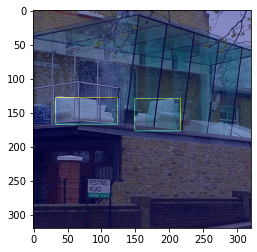


Total no of images:  4617


In [ ]:
print("Image with its bounding boxes")
disp_box(image_f[2],box_f[2])
print("\nTotal no of images: ", len(image_f))

#Building the Region proposal network (RPN)

##extracting features from pretrained model

In [ ]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [ ]:
from torchvision.models import resnet18
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for resnet50.
m = resnet18(pretrained= True)
train_nodes, eval_nodes = get_graph_node_names(resnet18())

#Doing requiregrsd =False for pretrained model
for param in m.parameters():
    param.requires_grad = False

m.requires_grad_(False)
m.eval()    #Sets required grad=True
print()

In [ ]:
print(eval_nodes)
print(train_nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

In [ ]:
return_nodes = {
    # node_name: user-specified key for output dict
    'layer4.1.relu_1': 'layer1'
}

In [ ]:
x = torch.tensor(image_f[0], device = DEVICE)
x = x.permute(2,0,1)

x = x.float()
x = x/255.0

In [ ]:
body = create_feature_extractor(m, return_nodes=return_nodes).to(DEVICE)
out = body(x.reshape(1, x.shape[0], x.shape[1], x.shape[2]))

In [ ]:
out['layer1'].shape       #we extract features from here (this layer)

torch.Size([1, 512, 10, 10])

In [ ]:
features = out['layer1']

Shape of the features extracted from third layer:  torch.Size([1, 512, 10, 10])


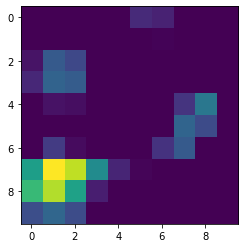

In [ ]:
print("Shape of the features extracted from third layer: ", features.shape)
ti = features.permute(0,2,3,1)
plt.imshow(ti.reshape(ti.shape[1],ti.shape[2],ti.shape[3])[:,:,1].detach().cpu().numpy())
plt.show()

In [ ]:
def feature_extract(backbone, img):   #backbone is body
  with torch.no_grad():
    out = backbone(img)
    features = out['layer1']
    return features

In [ ]:
ff = feature_extract(body, x.reshape(1,x.shape[0] ,x.shape[1] ,x.shape[2]))
print(ff.shape)

torch.Size([1, 512, 10, 10])


##Making a layer which predits if anchor box has object or not and, predicts anchor transforms 

In [ ]:
#For predicting anchor box
class RPN(nn.Module):

  def __init__(self, in_channels):
    super(RPN, self).__init__()
    self.conv1 = nn.Conv2d(512, 6, 3, 1, 1, bias=True)  # output(6,10,10)

  def forward(self,img):
    out = self.conv1(img)  
    return out   
    

In [ ]:
#For predicting anchor box
class RPTransform(nn.Module):

  def __init__(self, in_channels):
    super(RPTransform, self).__init__()
    self.conv1 = nn.Conv2d(512, 24, 3, 1, 1, bias=True)  # output(24,10,10)

  def forward(self,img):
    out = self.conv1(img)  
    return out 

In [ ]:
rpn = RPN(512).to(DEVICE)

In [ ]:
anchor = rpn(ff)
print(anchor.shape)

torch.Size([1, 6, 10, 10])


In [ ]:
rptransform = RPTransform(512).to(DEVICE)


In [ ]:
transform = rptransform(ff)
print(transform.shape)

torch.Size([1, 24, 10, 10])


##Some calculations to get the loss function:

In [ ]:
#projection of points on 
stride = 320/10


In [ ]:
tt = [0.5 , 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
points = []
for i in tt:
  for j in tt:
    points.append([int(i*stride), int(j*stride)])

In [ ]:
ploting = torch.zeros((320,320), device = DEVICE, dtype = torch.float32)
for i in range(len(points)):
  ploting[points[i][0], points[i][1]] = 1.0       #(y,x) 
  ploting[points[i][0]+1, points[i][1]+1] = 1.0   #Just to make the dots more visible
  ploting[points[i][0]-1, points[i][1]-1] = 1.0   #Just to make the dots more visible

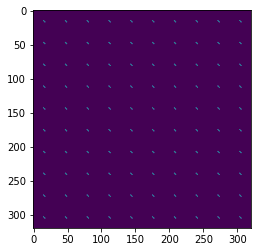

In [ ]:
plt.imshow(ploting.cpu().numpy())    #see the dots, they are the points from one feature level to another
plt.show()

In [ ]:
#Producing coordinates for each points:
lengths = [[30,30], [40,60], [60,40], [80,60], [60,80], [100,100]]
box = []

for i in range(len(points)):
  temp = []
  for j in lengths:
    x1 = (points[i][1] - int(j[0]/2))
    if x1<0:
      x1 = 0

    y1 = (points[i][1] - int(j[1]/2))
    if y1<0:
      y1 = 0

    x2 = (points[i][1] + int(j[0]/2))
    if x2<0:
      x2 = 0

    y2 = (points[i][1] + int(j[1]/2))
    if y2<0:
      y2 = 0

    temp.append([x1, y1, x2, y2])

  box.append(temp)


In [ ]:
print(box)
print(points)
print("no of points: ", len(box))

[[[1, 1, 31, 31], [0, 0, 36, 46], [0, 0, 46, 36], [0, 0, 56, 46], [0, 0, 46, 56], [0, 0, 66, 66]], [[33, 33, 63, 63], [28, 18, 68, 78], [18, 28, 78, 68], [8, 18, 88, 78], [18, 8, 78, 88], [0, 0, 98, 98]], [[65, 65, 95, 95], [60, 50, 100, 110], [50, 60, 110, 100], [40, 50, 120, 110], [50, 40, 110, 120], [30, 30, 130, 130]], [[97, 97, 127, 127], [92, 82, 132, 142], [82, 92, 142, 132], [72, 82, 152, 142], [82, 72, 142, 152], [62, 62, 162, 162]], [[129, 129, 159, 159], [124, 114, 164, 174], [114, 124, 174, 164], [104, 114, 184, 174], [114, 104, 174, 184], [94, 94, 194, 194]], [[161, 161, 191, 191], [156, 146, 196, 206], [146, 156, 206, 196], [136, 146, 216, 206], [146, 136, 206, 216], [126, 126, 226, 226]], [[193, 193, 223, 223], [188, 178, 228, 238], [178, 188, 238, 228], [168, 178, 248, 238], [178, 168, 238, 248], [158, 158, 258, 258]], [[225, 225, 255, 255], [220, 210, 260, 270], [210, 220, 270, 260], [200, 210, 280, 270], [210, 200, 270, 280], [190, 190, 290, 290]], [[257, 257, 287, 28

In [ ]:
box_f[0][0]

(32.00000000000001, 150.0, 179.0, 281.0, 4)

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
bb1 = {'x1': box[0][0][0], 'x2': box[0][0][2], 'y1':box[0][0][1] , 'y2':box[0][0][3]}
bb2 = {'x1':box_f[0][0][0] , 'x2':box_f[0][0][2] , 'y1':box_f[0][0][1] , 'y2':box_f[0][0][3]}
get_iou(bb1, bb2)

0.0

In [ ]:
xx = torch.tensor(box_f[0][0], dtype = torch.int32)
print(xx[1:5])

tensor([150, 179, 281,   4], dtype=torch.int32)


In [ ]:
box_f[0]

[(32.00000000000001, 150.0, 179.0, 281.0, 4), (0.0, 0.0, 320.0, 320.0, 0)]

In [ ]:
#Making 6 boxes around each point 
# 30*30, 40*60, 60*40, 80*60, 60*80, 100*100  (these are hyperparameters)
anchor = torch.zeros((len(box_f), 6, 10, 10), device= DEVICE)
anchor_transform = torch.zeros((len(box_f), 24, 10, 10), device= DEVICE)
for i in range(len(box_f)):
  for m in range(len(box_f[i])):
    for j in range(len(box)):
      for k in range(6):
        bb1 = {'x1': box[j][k][0], 'x2': box[j][k][2], 'y1':box[j][k][1] , 'y2':box[j][k][3]}
        bb2 = {'x1':box_f[i][m][0] , 'x2':box_f[i][m][2] , 'y1':box_f[i][m][1] , 'y2':box_f[i][m][3]}
        iou = get_iou(bb1, bb2)
        if iou >= 0.5:
          nt = int(j/10)
          #anchor box
          anchor[i,k, nt, int(j - nt*10)] = 1.0

          #anchor transform
          







In [ ]:
print(anchor[0].shape)

torch.Size([6, 10, 10])


In [ ]:
print(anchor.shape)
num_t = 0
for i in range(anchor.shape[0]):
  for j in range(anchor.shape[1]):
    for k in range(anchor.shape[2]):
      for l in range(anchor.shape[3]):
        if anchor[i,j,k,l] == 1.0:
          num_t += 1

print("No of boxes which has abject inside it: ", num_t)

torch.Size([4617, 6, 10, 10])
No of boxes which has abject inside it:  11160


In [ ]:
len(box_f)
numt = 0
for i in range(len(box_f)):
  for j in range(len(box_f[i])):
    numt += 1

print("total no of boxes: ", numt) 

total no of boxes:  12015


#Training the RPN network

In [ ]:
optimizer = torch.optim.Adam(rpn.parameters(), lr=0.01)

loss_type = nn.L1Loss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 50, gamma = 0.75)   #Every 50 epochs our learning rate will be multiplied by gamma

In [ ]:
#Model Training
loss_graph = []

num_epochs = 10000
num_train = len(image_f)
batch_size = 100
for i in range(num_epochs):
  images = []
  boxes = []
  
  random_no = torch.randint(0, 4000, (batch_size,)).cpu().numpy()
  for j in random_no:
    images.append(image_f[j])
  images = torch.tensor(np.array(images), device=DEVICE, dtype = torch.float32)

  for j in random_no:
      boxes.append(anchor[j].cpu().numpy())
  boxes = torch.tensor(np.array(boxes), device=DEVICE)
  
  rpn.train()
  optimizer.zero_grad()
  images /= 255.0
  images = images.permute(0,3,1,2)
  
  ff = feature_extract(body, images)
  y_pred = rpn(ff)

  y_batch = boxes
  #y_batch = y_batch.reshape(1, y_batch.shape[0],y_batch.shape[1], y_batch.shape[2] )
  
  loss = loss_type(y_pred, y_batch)
  loss.backward()
  optimizer.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

Epoch:  0 , loss is:  1.3075134754180908
Epoch:  10 , loss is:  0.9538413286209106
Epoch:  20 , loss is:  1.417353868484497
Epoch:  30 , loss is:  2.7326037883758545
Epoch:  40 , loss is:  1.9482289552688599
Epoch:  50 , loss is:  2.7745020389556885
Epoch:  60 , loss is:  2.9629812240600586
Epoch:  70 , loss is:  2.059839963912964
Epoch:  80 , loss is:  2.8432395458221436
Epoch:  90 , loss is:  2.4583380222320557
Epoch:  100 , loss is:  2.822864055633545
Epoch:  110 , loss is:  2.6558995246887207
Epoch:  120 , loss is:  3.1912412643432617
Epoch:  130 , loss is:  2.7795212268829346
Epoch:  140 , loss is:  2.755228042602539
Epoch:  150 , loss is:  2.9414303302764893
Epoch:  160 , loss is:  2.7782464027404785
Epoch:  170 , loss is:  2.9359776973724365
Epoch:  180 , loss is:  3.2374088764190674
Epoch:  190 , loss is:  2.813946485519409
Epoch:  200 , loss is:  3.180630683898926
Epoch:  210 , loss is:  3.0021862983703613
Epoch:  220 , loss is:  2.820340394973755
Epoch:  230 , loss is:  2.579

In [ ]:
print(images.shape)
print(y_pred.shape)

torch.Size([100, 3, 320, 320])
torch.Size([100, 6, 10, 10])


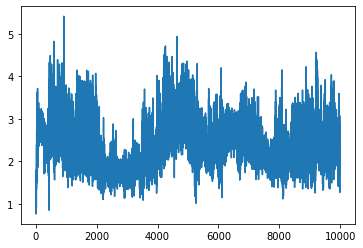

In [ ]:
plt.plot(loss_graph)

In [ ]:
idx = 600
ix = torch.tensor(image_f[idx], device = DEVICE, dtype = torch.float32)
ix /= 255.0
ix = ix.permute(2,0,1)
  
ff = feature_extract(body, ix.reshape(1,ix.shape[0] ,ix.shape[1] ,ix.shape[2]))
y_pred = rpn(ff)

In [ ]:
print(y_pred.shape)
y_pred = y_pred.reshape(y_pred.shape[1], y_pred.shape[2], y_pred.shape[3])
print(y_pred.shape)
m = nn.Softmax(dim=0)
output = m(y_pred)

output[output<0.8] = 0
output[output>=0.8] = 1
print(output.shape)                       #This is prediction for the boxes

torch.Size([1, 6, 10, 10])
torch.Size([6, 10, 10])
torch.Size([6, 10, 10])


In [ ]:
#Creating box list:
box1 = []

for i in range(output.shape[0]):
  for j in range(output.shape[1]):
    for k in range(output.shape[2]):
      if output[i,j,k] >0.9:
        box1.append(box[int(j*10 + k)][i])




In [ ]:
print(len(box))
print(output.shape)
box[0][0]

100
torch.Size([6, 10, 10])


[1, 1, 31, 31]

In [ ]:
print(output.shape)
print(len(box))
box[1][1]

torch.Size([6, 10, 10])
100


[28, 18, 68, 78]

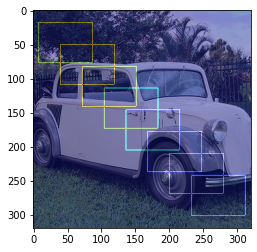

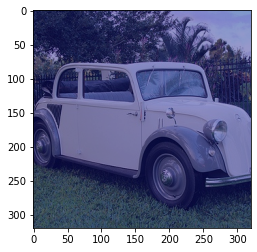

In [ ]:
disp_box(image_f[idx],box1)    #box1 is 2d list
disp_box(image_f[idx], box_f[idx])